In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [13]:
# 用于 DataLoader 的 transform
transform = transforms.Compose([
    transforms.ToTensor()
])


dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be at least 1
print(torch.cuda.get_device_name(0))  # Should print "GeForce GTX 1660 Ti"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


True
1
NVIDIA GeForce GTX 1660 Ti


In [14]:
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1) # 3x3 kernel, stride 1
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.fc = nn.Linear(10 * 24 * 24, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




In [15]:
dropout_rates = [0.25, 0.5, 0.75]
train_losses, val_losses = {}, {}
for rate in dropout_rates:
    print(f"\n=== Training with Dropout {rate} ===")
    model = CNNWithDropout(rate).to(device)

    # Xavier Initialization
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(layer.weight)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

    train_losses[str(rate)], val_losses[str(rate)] = [], []
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(100):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses[str(rate)].append(avg_train_loss)

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                loss = criterion(model(images), labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses[str(rate)].append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'best_model_dropout_{rate}.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > 5:
                print("Early stopping.")
                break



=== Training with Dropout 0.25 ===
Epoch 1, Train Loss: 0.3671, Val Loss: 0.1561
Epoch 2, Train Loss: 0.2001, Val Loss: 0.1230
Epoch 3, Train Loss: 0.1648, Val Loss: 0.1053
Epoch 4, Train Loss: 0.1430, Val Loss: 0.1093
Epoch 5, Train Loss: 0.1276, Val Loss: 0.0927
Epoch 6, Train Loss: 0.1201, Val Loss: 0.0984
Epoch 7, Train Loss: 0.1137, Val Loss: 0.1049
Epoch 8, Train Loss: 0.1088, Val Loss: 0.0964
Epoch 9, Train Loss: 0.1010, Val Loss: 0.1039
Epoch 10, Train Loss: 0.1000, Val Loss: 0.1224
Epoch 11, Train Loss: 0.0904, Val Loss: 0.1060
Early stopping.

=== Training with Dropout 0.5 ===
Epoch 1, Train Loss: 1.1675, Val Loss: 0.2615
Epoch 2, Train Loss: 0.9852, Val Loss: 0.2141
Epoch 3, Train Loss: 0.9284, Val Loss: 0.1768
Epoch 4, Train Loss: 0.8984, Val Loss: 0.1716
Epoch 5, Train Loss: 0.8762, Val Loss: 0.1552
Epoch 6, Train Loss: 0.8903, Val Loss: 0.1808
Epoch 7, Train Loss: 0.9223, Val Loss: 0.1762
Epoch 8, Train Loss: 0.8998, Val Loss: 0.1451
Epoch 9, Train Loss: 0.8688, Val Loss

In [16]:
import numpy as np
for rate in dropout_rates:
    print(f"\n=== Testing with Dropout {rate} ===")
    model = CNNWithDropout(rate).to(device)
    model.load_state_dict(torch.load(f'best_model_dropout_{rate}.pth'))
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


=== Testing with Dropout 0.25 ===
Test Accuracy: 97.33%

=== Testing with Dropout 0.5 ===
Test Accuracy: 97.04%

=== Testing with Dropout 0.75 ===
Test Accuracy: 70.38%



=== Evaluating Dropout 0.25 ===


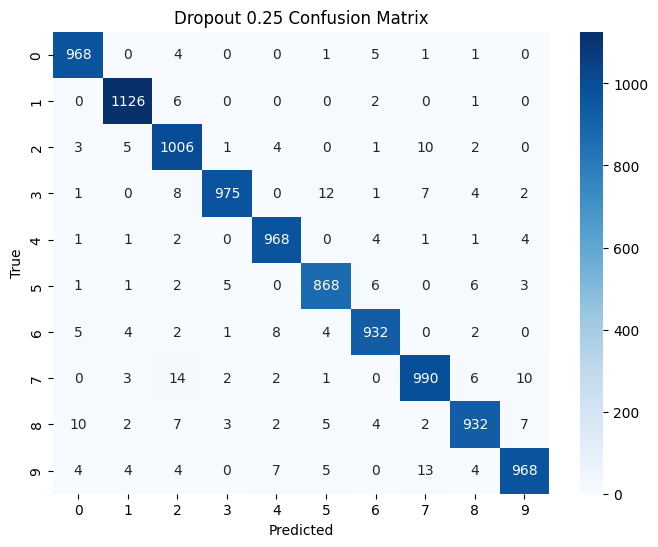

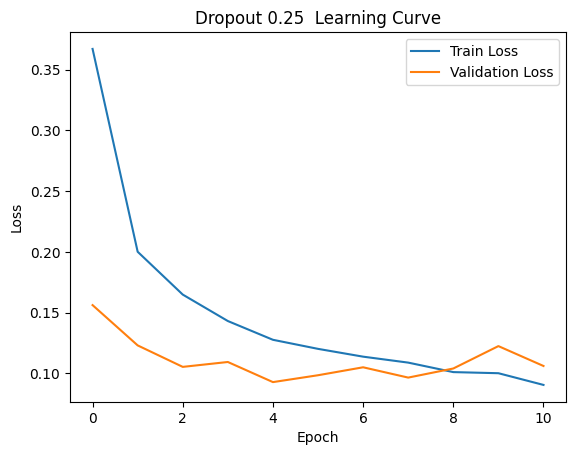


=== Evaluating Dropout 0.5 ===


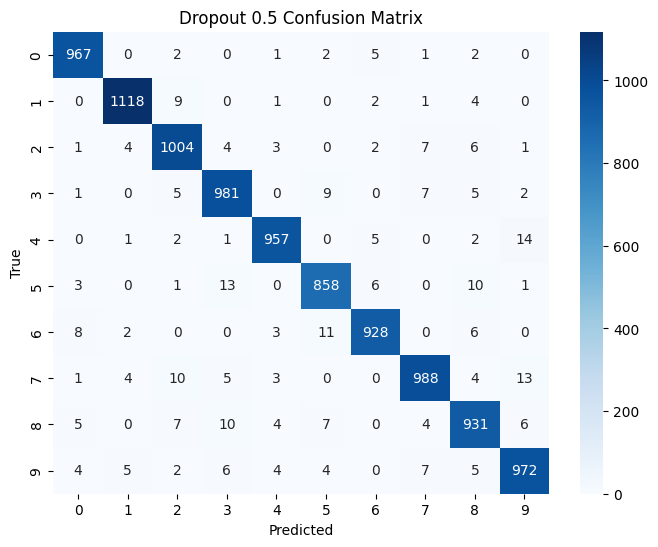

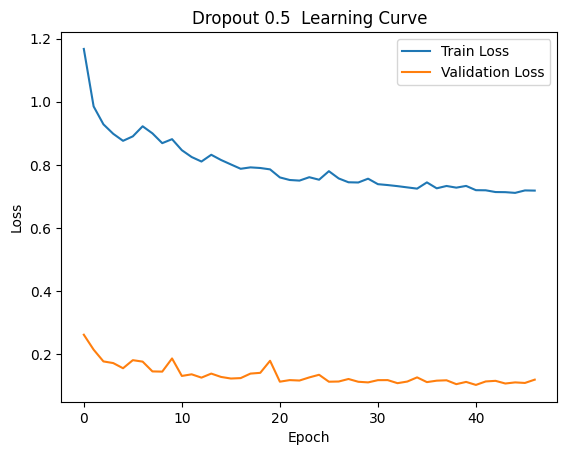


=== Evaluating Dropout 0.75 ===


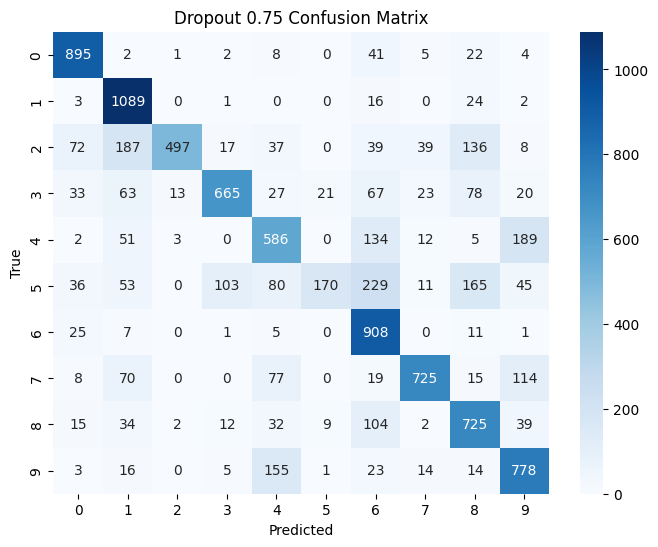

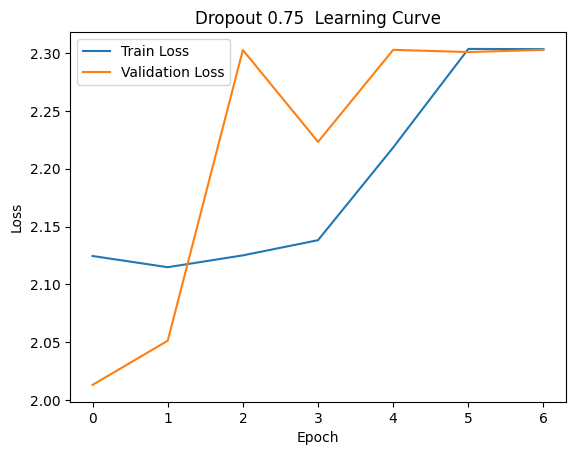

In [17]:
dropout_rates = [0.25, 0.5, 0.75]

for rate in dropout_rates:
    print(f"\n=== Evaluating Dropout {rate} ===")

    # Reload corresponding model
    model = CNNWithDropout(rate).to(device)
    model.load_state_dict(torch.load(f'best_model_dropout_{rate}.pth'))
    model.eval()

    # Containers for evaluation
    all_preds, all_labels = [], []
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Dropout {rate} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.plot(train_losses[str(rate)], label='Train Loss')
    plt.plot(val_losses[str(rate)], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Dropout {rate}  Learning Curve')
    plt.show()

The first 2 are reasonably fiting the validation data. Dropout with rate 0.75 is underfiting because the loss increases as the epoch increases.


=== Kernel of Dropout 0.25 ===


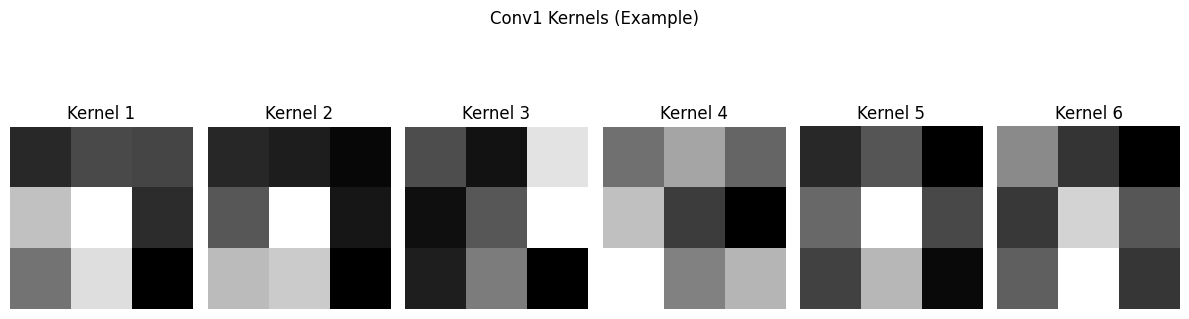

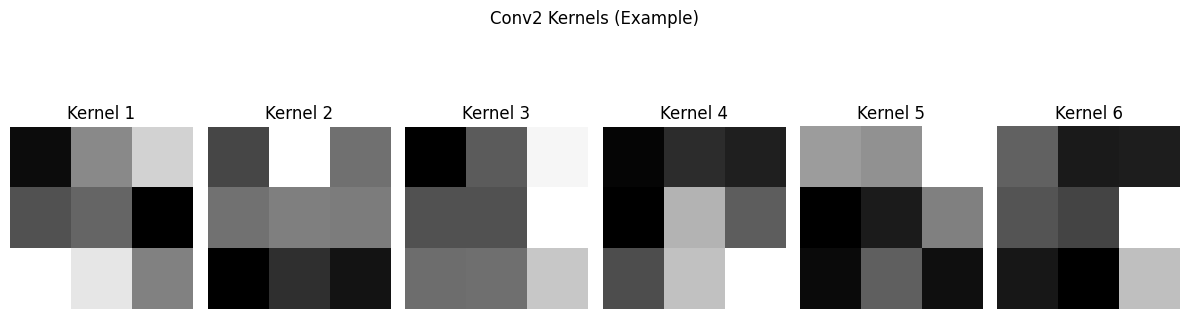


=== Kernel of Dropout 0.5 ===


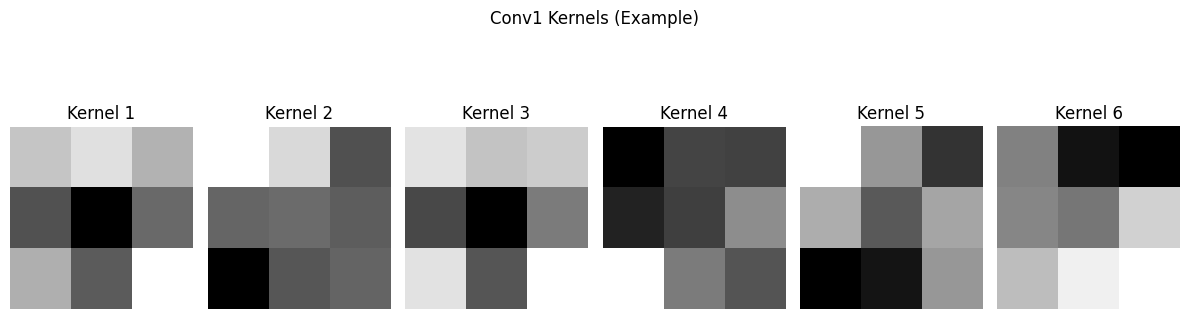

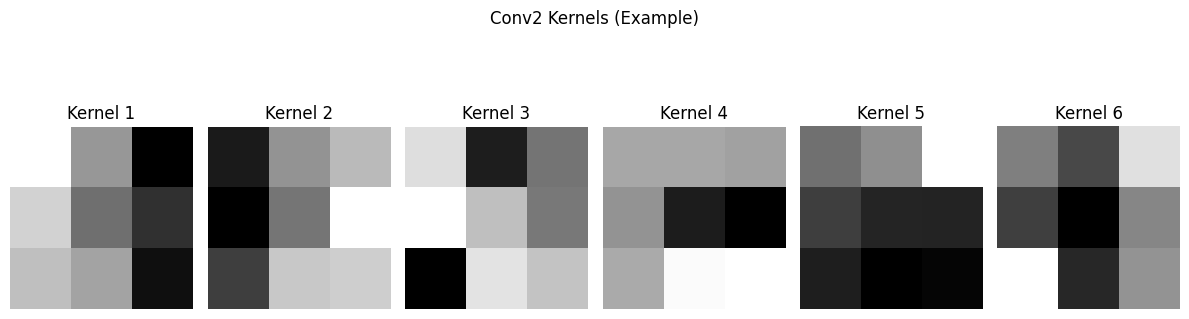


=== Kernel of Dropout 0.75 ===


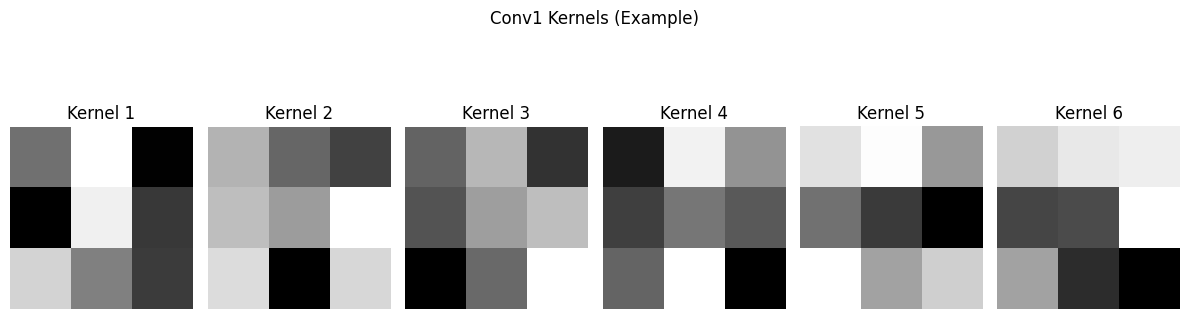

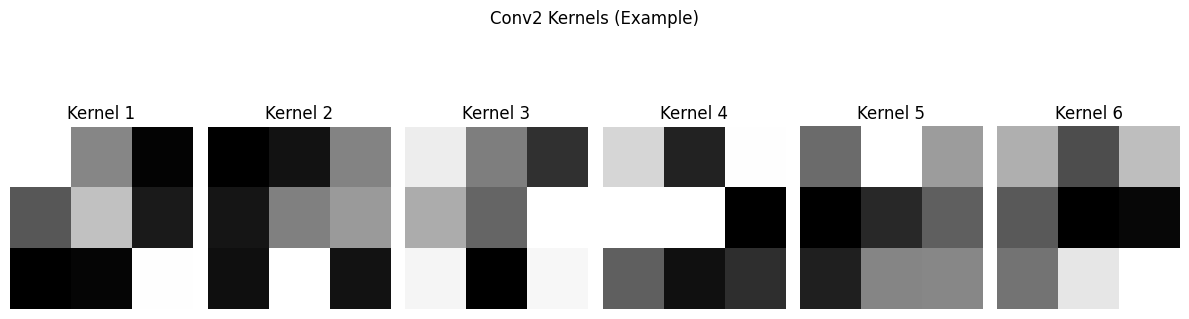

In [18]:
# Visualize a subset of kernels from conv1
def visualize_kernels(layer, title, num_kernels=6):
    with torch.no_grad():
        kernels = layer.weight.cpu().numpy()  # shape: (out_channels, in_channels, H, W)
        fig, axes = plt.subplots(1, num_kernels, figsize=(12, 4))
        fig.suptitle(title)

        for i in range(num_kernels):
            kernel = kernels[i, 0]  # visualize the first input channel
            axes[i].imshow(kernel, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Kernel {i+1}')

        plt.tight_layout()
        plt.show()


dropout_rates = [0.25, 0.5, 0.75]

for rate in dropout_rates:
    print(f"\n=== Kernel of Dropout {rate} ===")

    # Reload corresponding model
    model = CNNWithDropout(rate).to(device)
    model.load_state_dict(torch.load(f'best_model_dropout_{rate}.pth'))
    visualize_kernels(model.conv1, title="Conv1 Kernels (Example)", num_kernels=6)
    visualize_kernels(model.conv2, title="Conv2 Kernels (Example)", num_kernels=6)